In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from data_loader import get_cifar100_loaders
from evaluation_utils import (evaluate_model, plot_confusion_matrix,
                              visualize_misclassified, get_cifar100_class_names)

In [2]:
def train_model(model, train_loader, test_loader, num_epochs, learning_rate, device, model_name="vgg16"):
    criterion = nn.CrossEntropyLoss()

    # SGD with momentum is often good for fine-tuning VGG
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
    # A scheduler can be very helpful for VGG
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    model.to(device)

    best_accuracy = 0.0
    model_save_path = f'{model_name}_cifar100_best.pth'

    train_acc_history = []
    test_acc_history = []

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training loop with tqdm progress bar
        train_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for i, (inputs, labels) in enumerate(train_iterator):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            train_iterator.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc_train = 100.0 * correct_train / total_train
        train_acc_history.append(epoch_acc_train)

        # Validation loop with tqdm progress bar
        model.eval()
        correct_test = 0
        total_test = 0
        test_iterator = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
        with torch.no_grad():
            for inputs, labels in test_iterator:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        epoch_acc_test = 100.0 * correct_test / total_test
        test_acc_history.append(epoch_acc_test)
        end_time = time.time()
        epoch_duration = end_time - start_time

        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc_train:.2f}% | '
              f'Test Acc: {epoch_acc_test:.2f}% | LR: {scheduler.get_last_lr()[0]:.6f} | '
              f'Duration: {epoch_duration:.2f}s')

        scheduler.step() # Update learning rate

        if epoch_acc_test > best_accuracy:
            best_accuracy = epoch_acc_test
            try:
                torch.save(model.state_dict(), model_save_path)
                print(f'>>> Best model saved to {model_save_path} with Test Accuracy: {best_accuracy:.2f}%')
            except Exception as e:
                 print(f"Lỗi khi lưu model: {e}")

    print('Finished Training')
    print(f'Best Validation Accuracy achieved during training: {best_accuracy:.2f}%')

    print(f"Loading best model state from {model_save_path} for final evaluation...")
    try:
        model.load_state_dict(torch.load(model_save_path))
        
    except Exception as e:
        print(f"Could not load best model state: {e}. Evaluating with the final model state.")

    return model, train_acc_history, test_acc_history


In [3]:
# --- Hyperparameters ---
NUM_EPOCHS = 20
BATCH_SIZE = 12 # VGG is memory intensive, might need smaller batch size
LEARNING_RATE = 0.001   # Initial learning rate for SGD (VGG is sensitive)
IMG_SIZE = 224          # VGG expects 224x224 input
USE_AUGMENTATION = True
DATA_DIR = './data_cifar100'
NUM_WORKERS = 10
MODEL_NAME = "3_VGG16"

Sử dụng thiết bị: cuda
Đang tải dữ liệu CIFAR-100 (resize: 224x224)...
Đã tải xong CIFAR-100.
Số lượng ảnh Train: 50000
Số lượng ảnh Test: 10000
Kích thước ảnh: 224x224
Sử dụng Data Augmentation: True
Khởi tạo VGG16 pre-trained model...
Đã thay thế lớp cuối cùng của VGG classifier bằng lớp Linear(4096, 100)
Bắt đầu fine-tuning VGG16...


Epoch 1/20 [Val]: 100%|██████████| 834/834 [00:43<00:00, 19.34it/s]


Epoch 1/20 | Train Loss: 2.9446 | Train Acc: 27.36% | Test Acc: 58.71% | LR: 0.001000 | Duration: 781.86s
>>> Best model saved to 3_VGG16_cifar100_best.pth with Test Accuracy: 58.71%


Epoch 2/20 [Val]: 100%|██████████| 834/834 [00:43<00:00, 19.18it/s]


Epoch 2/20 | Train Loss: 2.2188 | Train Acc: 42.22% | Test Acc: 64.90% | LR: 0.001000 | Duration: 785.82s
>>> Best model saved to 3_VGG16_cifar100_best.pth with Test Accuracy: 64.90%


Epoch 3/20 [Val]: 100%|██████████| 834/834 [00:43<00:00, 19.21it/s]


Epoch 3/20 | Train Loss: 2.0186 | Train Acc: 46.58% | Test Acc: 67.36% | LR: 0.001000 | Duration: 787.07s
>>> Best model saved to 3_VGG16_cifar100_best.pth with Test Accuracy: 67.36%


Epoch 4/20 [Val]: 100%|██████████| 834/834 [00:43<00:00, 19.39it/s]


Epoch 4/20 | Train Loss: 1.8864 | Train Acc: 49.52% | Test Acc: 67.35% | LR: 0.001000 | Duration: 788.13s


Epoch 5/20 [Val]: 100%|██████████| 834/834 [00:43<00:00, 19.27it/s]


Epoch 5/20 | Train Loss: 1.8027 | Train Acc: 51.69% | Test Acc: 69.84% | LR: 0.001000 | Duration: 787.08s
>>> Best model saved to 3_VGG16_cifar100_best.pth with Test Accuracy: 69.84%


Epoch 6/20 [Val]: 100%|██████████| 834/834 [00:43<00:00, 19.23it/s]


Epoch 6/20 | Train Loss: 1.7345 | Train Acc: 53.26% | Test Acc: 71.27% | LR: 0.001000 | Duration: 786.76s
>>> Best model saved to 3_VGG16_cifar100_best.pth with Test Accuracy: 71.27%


Epoch 7/20 [Val]: 100%|██████████| 834/834 [00:43<00:00, 19.19it/s]


Epoch 7/20 | Train Loss: 1.6761 | Train Acc: 54.78% | Test Acc: 71.15% | LR: 0.001000 | Duration: 785.65s


Epoch 8/20 [Val]: 100%|██████████| 834/834 [00:43<00:00, 19.14it/s]


Epoch 8/20 | Train Loss: 1.6289 | Train Acc: 56.14% | Test Acc: 72.87% | LR: 0.001000 | Duration: 785.97s
>>> Best model saved to 3_VGG16_cifar100_best.pth with Test Accuracy: 72.87%


Epoch 9/20 [Val]: 100%|██████████| 834/834 [00:43<00:00, 19.10it/s]


Epoch 9/20 | Train Loss: 1.5931 | Train Acc: 56.57% | Test Acc: 73.29% | LR: 0.001000 | Duration: 786.98s
>>> Best model saved to 3_VGG16_cifar100_best.pth with Test Accuracy: 73.29%


Epoch 10/20 [Val]: 100%|██████████| 834/834 [00:43<00:00, 19.24it/s]


Epoch 10/20 | Train Loss: 1.5582 | Train Acc: 57.38% | Test Acc: 72.24% | LR: 0.001000 | Duration: 782.39s


Epoch 11/20 [Val]: 100%|██████████| 834/834 [00:43<00:00, 19.31it/s]


Epoch 11/20 | Train Loss: 1.3068 | Train Acc: 63.65% | Test Acc: 77.68% | LR: 0.000100 | Duration: 781.80s
>>> Best model saved to 3_VGG16_cifar100_best.pth with Test Accuracy: 77.68%


Epoch 12/20 [Val]: 100%|██████████| 834/834 [00:43<00:00, 19.26it/s]


Epoch 12/20 | Train Loss: 1.2386 | Train Acc: 65.41% | Test Acc: 78.28% | LR: 0.000100 | Duration: 783.31s
>>> Best model saved to 3_VGG16_cifar100_best.pth with Test Accuracy: 78.28%


Epoch 13/20 [Val]: 100%|██████████| 834/834 [00:43<00:00, 19.31it/s]


Epoch 13/20 | Train Loss: 1.1995 | Train Acc: 66.23% | Test Acc: 78.45% | LR: 0.000100 | Duration: 783.28s
>>> Best model saved to 3_VGG16_cifar100_best.pth with Test Accuracy: 78.45%


Epoch 14/20 [Val]: 100%|██████████| 834/834 [00:43<00:00, 19.12it/s]


Epoch 14/20 | Train Loss: 1.1683 | Train Acc: 67.24% | Test Acc: 78.69% | LR: 0.000100 | Duration: 783.34s
>>> Best model saved to 3_VGG16_cifar100_best.pth with Test Accuracy: 78.69%


Epoch 15/20 [Val]: 100%|██████████| 834/834 [00:43<00:00, 19.26it/s]


Epoch 15/20 | Train Loss: 1.1542 | Train Acc: 67.48% | Test Acc: 79.18% | LR: 0.000100 | Duration: 781.61s
>>> Best model saved to 3_VGG16_cifar100_best.pth with Test Accuracy: 79.18%


Epoch 16/20 [Val]: 100%|██████████| 834/834 [00:43<00:00, 19.30it/s]


Epoch 16/20 | Train Loss: 1.1373 | Train Acc: 67.87% | Test Acc: 79.25% | LR: 0.000100 | Duration: 779.58s
>>> Best model saved to 3_VGG16_cifar100_best.pth with Test Accuracy: 79.25%


Epoch 17/20 [Val]: 100%|██████████| 834/834 [00:43<00:00, 19.33it/s]


Epoch 17/20 | Train Loss: 1.1166 | Train Acc: 68.31% | Test Acc: 79.48% | LR: 0.000100 | Duration: 779.19s
>>> Best model saved to 3_VGG16_cifar100_best.pth with Test Accuracy: 79.48%


Epoch 18/20 [Val]: 100%|██████████| 834/834 [00:43<00:00, 19.38it/s]


Epoch 18/20 | Train Loss: 1.1153 | Train Acc: 68.62% | Test Acc: 79.35% | LR: 0.000100 | Duration: 779.86s


Epoch 19/20 [Val]: 100%|██████████| 834/834 [00:43<00:00, 19.37it/s]


Epoch 19/20 | Train Loss: 1.1042 | Train Acc: 68.71% | Test Acc: 79.60% | LR: 0.000100 | Duration: 779.16s
>>> Best model saved to 3_VGG16_cifar100_best.pth with Test Accuracy: 79.60%


Epoch 20/20 [Val]: 100%|██████████| 834/834 [00:43<00:00, 19.15it/s]


Epoch 20/20 | Train Loss: 1.0832 | Train Acc: 69.43% | Test Acc: 79.72% | LR: 0.000100 | Duration: 778.73s
>>> Best model saved to 3_VGG16_cifar100_best.pth with Test Accuracy: 79.72%
Finished Training
Best Validation Accuracy achieved during training: 79.72%
Loading best model state from 3_VGG16_cifar100_best.pth for final evaluation...

--- Performing Final Evaluation on Test Set ---
Evaluating on test set...


  0%|          | 0/834 [00:00<?, ?it/s]


Classification Report:
               precision    recall  f1-score   support

        apple       0.92      0.93      0.93       100
aquarium_fish       0.90      0.94      0.92       100
         baby       0.69      0.75      0.72       100
         bear       0.81      0.73      0.77       100
       beaver       0.53      0.70      0.60       100
          bed       0.77      0.82      0.79       100
          bee       0.72      0.89      0.79       100
       beetle       0.89      0.77      0.82       100
      bicycle       0.95      0.92      0.93       100
       bottle       0.93      0.89      0.91       100
         bowl       0.70      0.55      0.61       100
          boy       0.52      0.49      0.50       100
       bridge       0.89      0.85      0.87       100
          bus       0.82      0.76      0.79       100
    butterfly       0.90      0.80      0.85       100
        camel       0.81      0.92      0.86       100
          can       0.82      0.83      

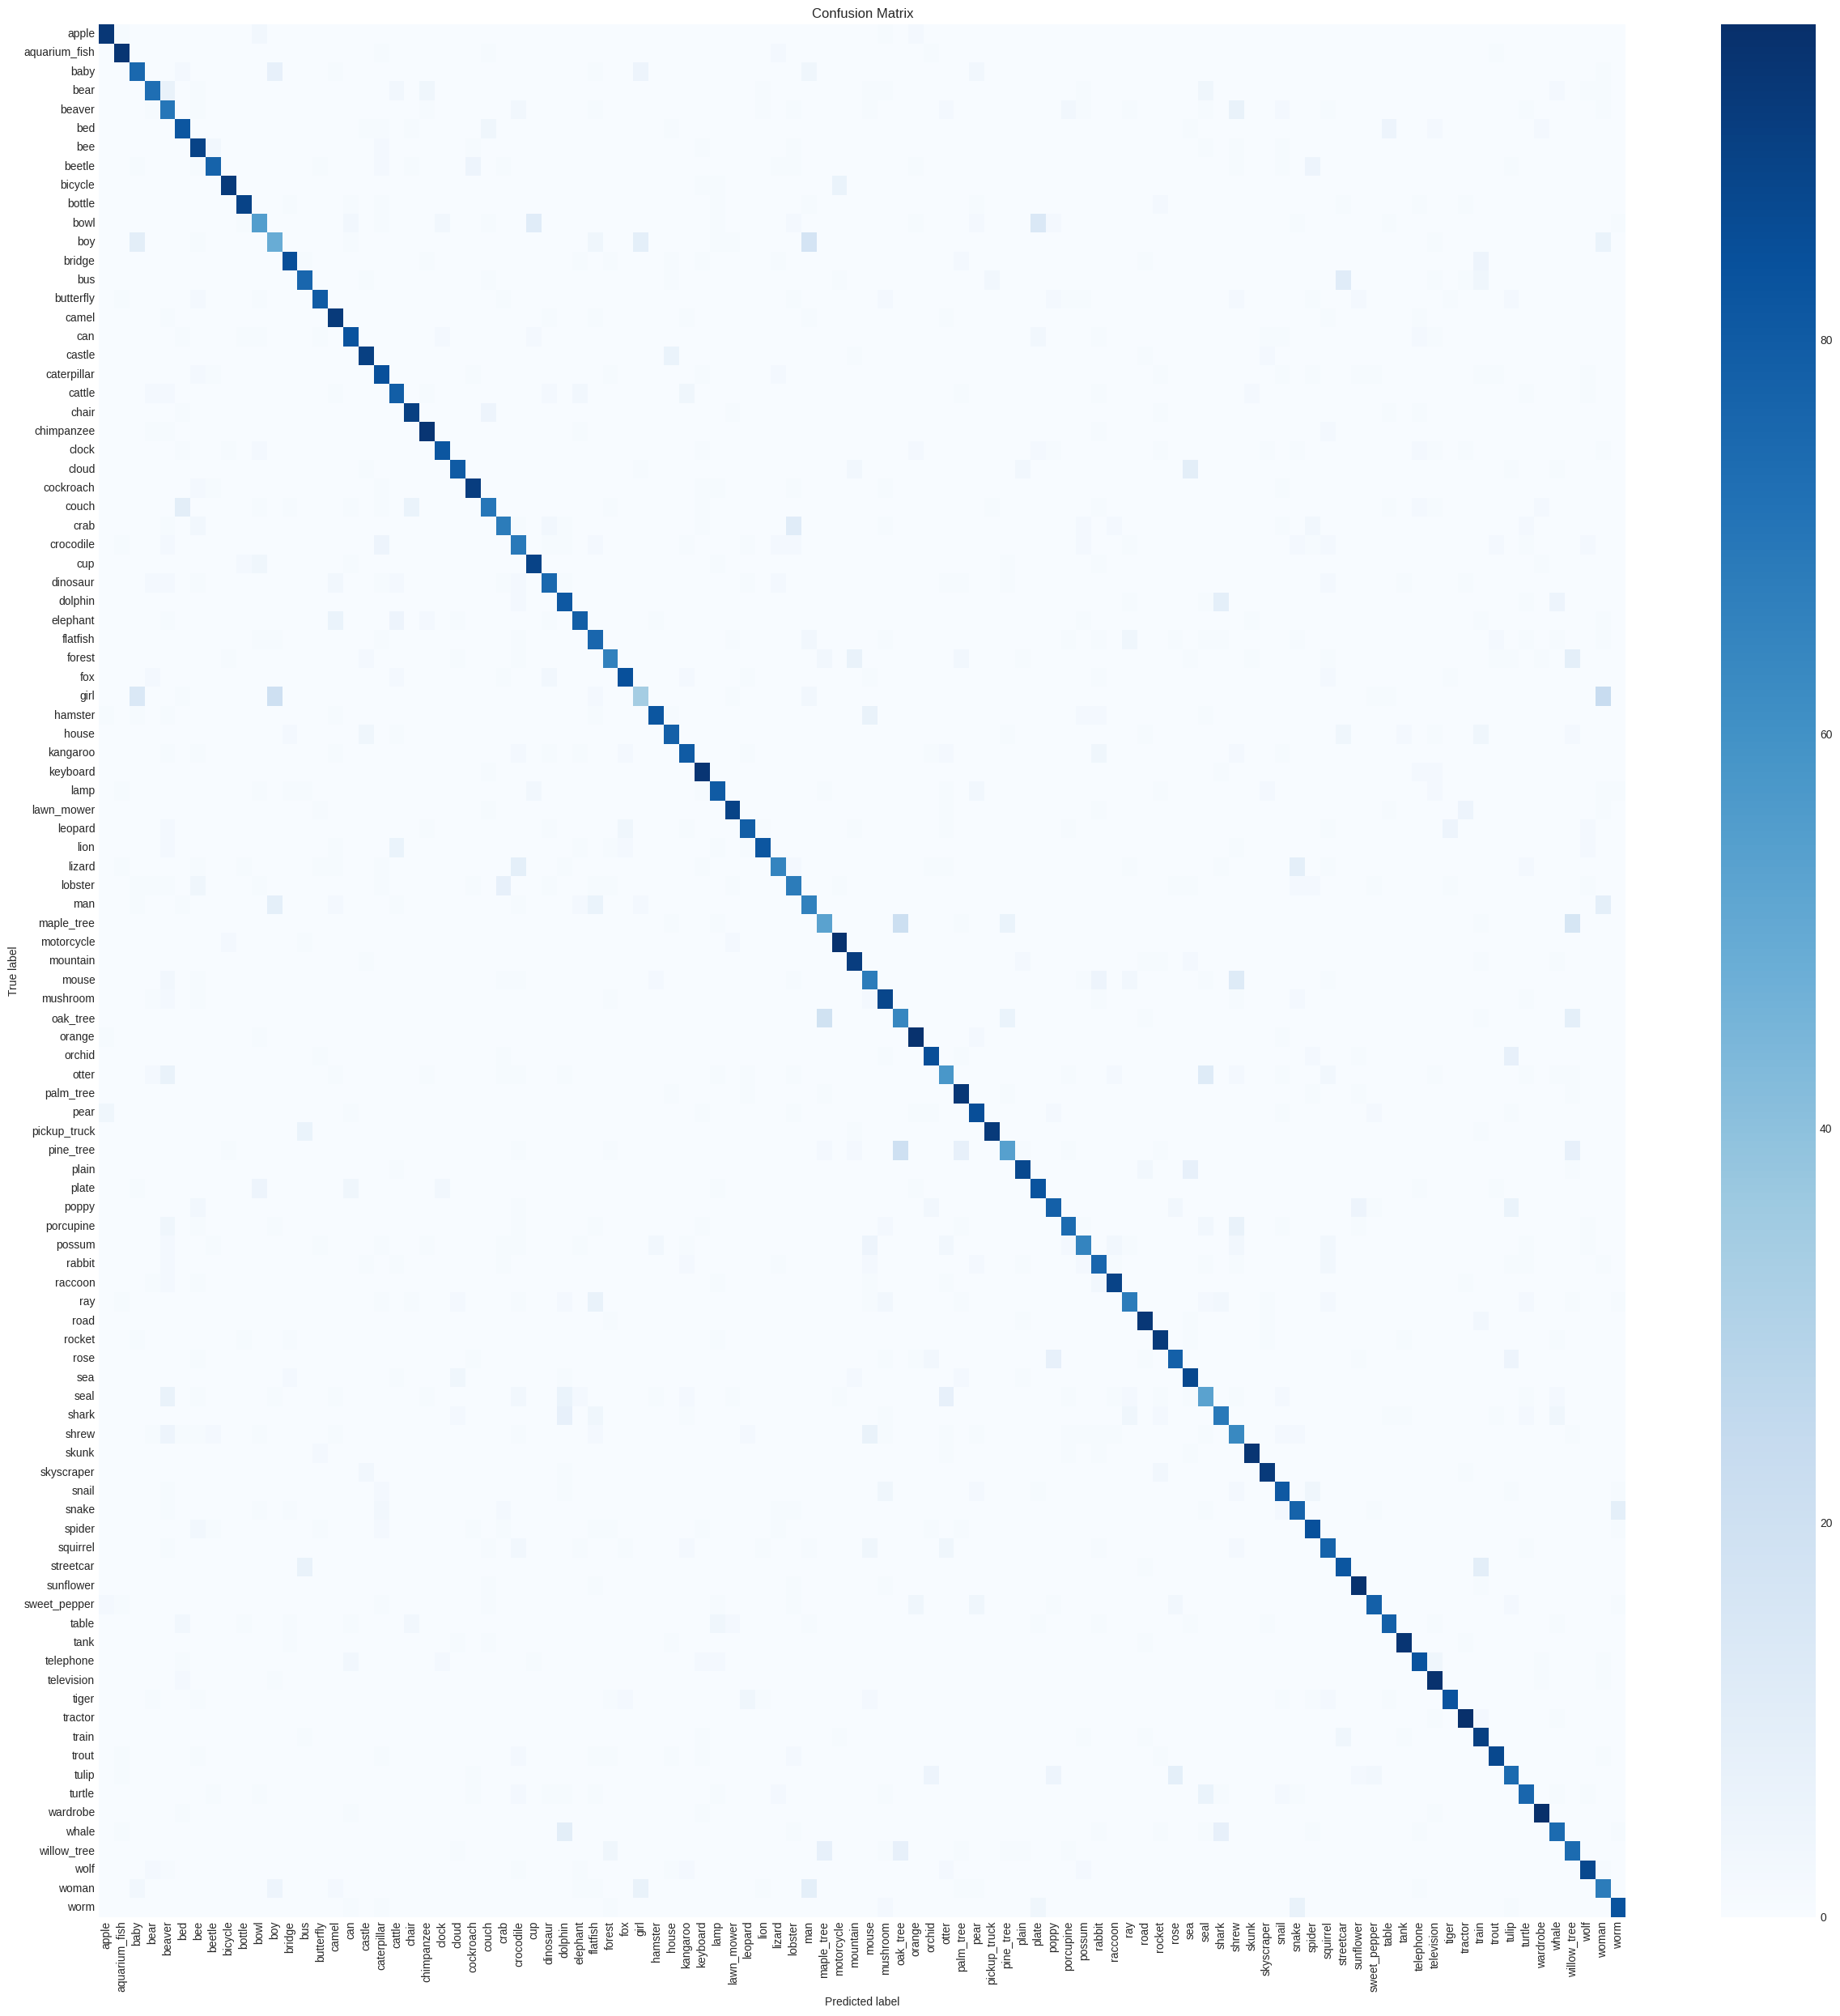


Searching for 25 misclassified images...


  0%|          | 0/834 [00:00<?, ?it/s]

Visualizing 25 misclassified images...
Misclassified images visualization saved to 3_VGG16_misclassified_25.png


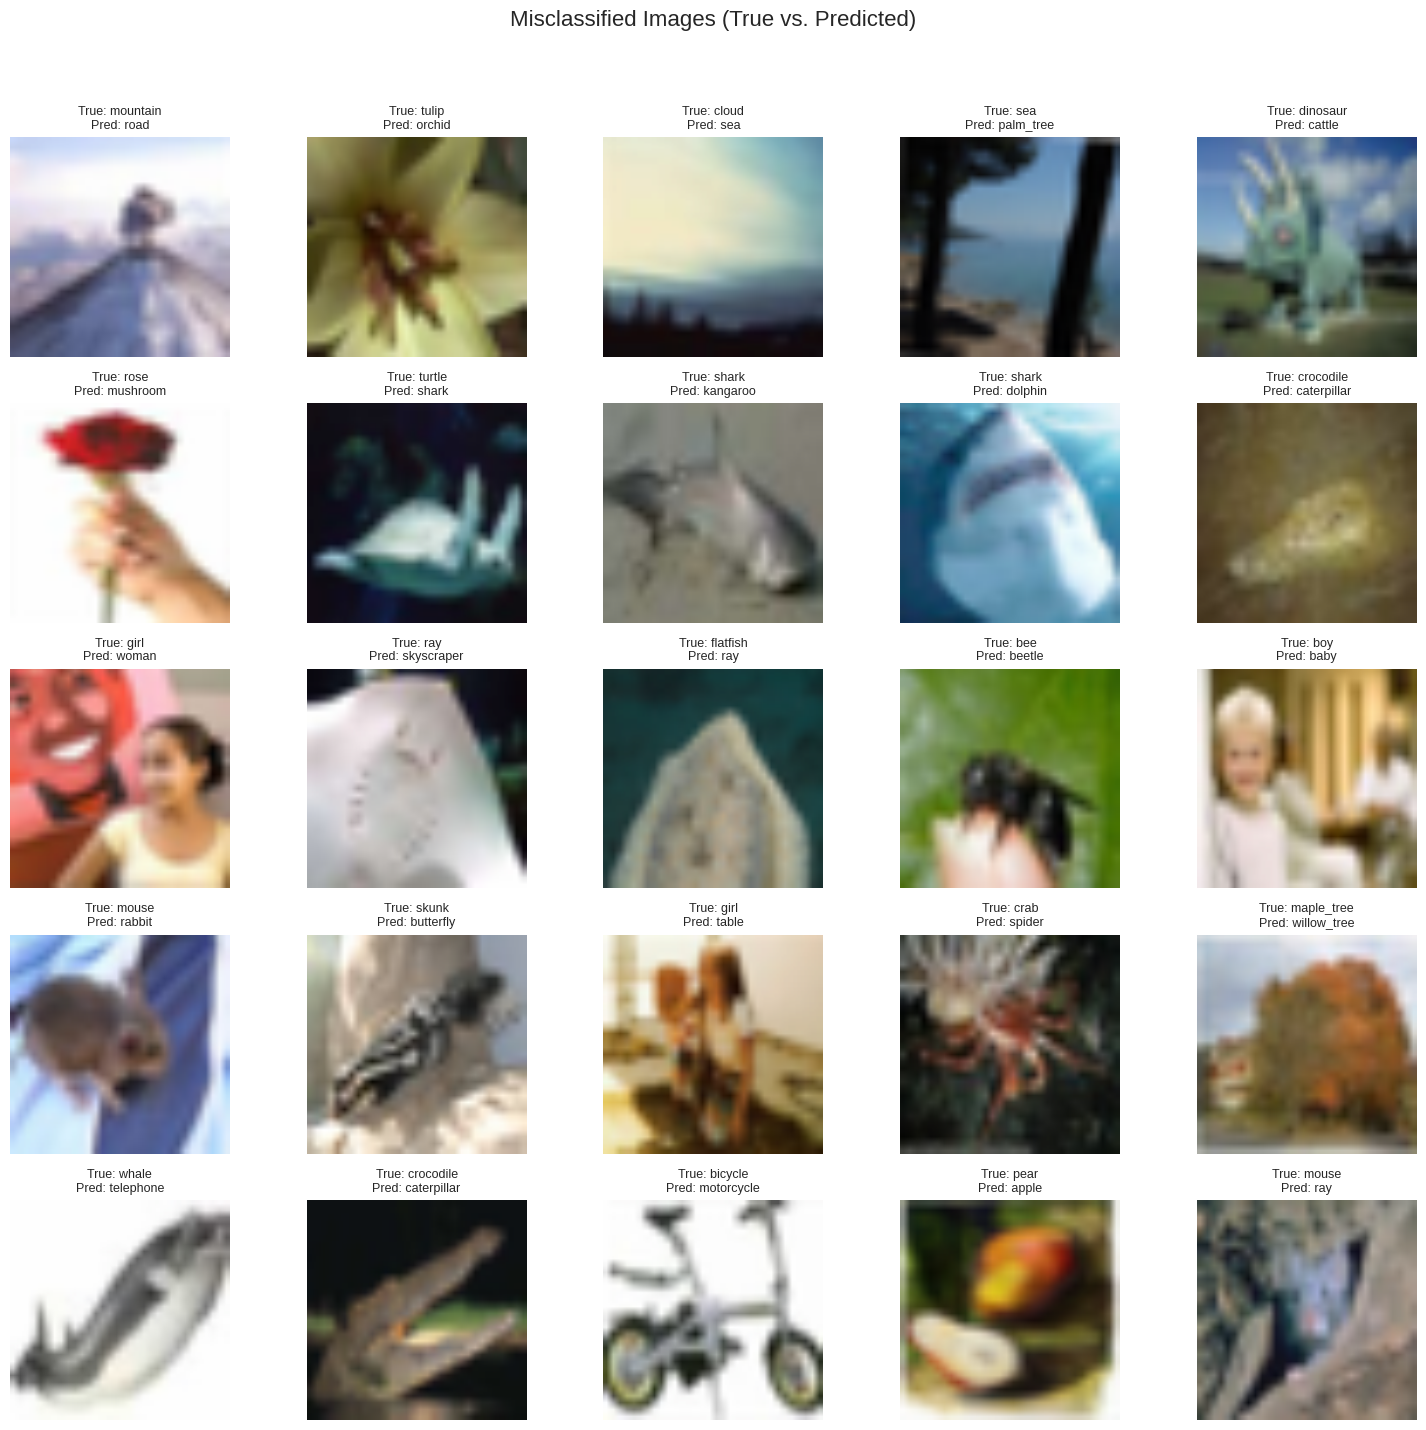

Accuracy history plot saved to 3_VGG16_accuracy_history.png


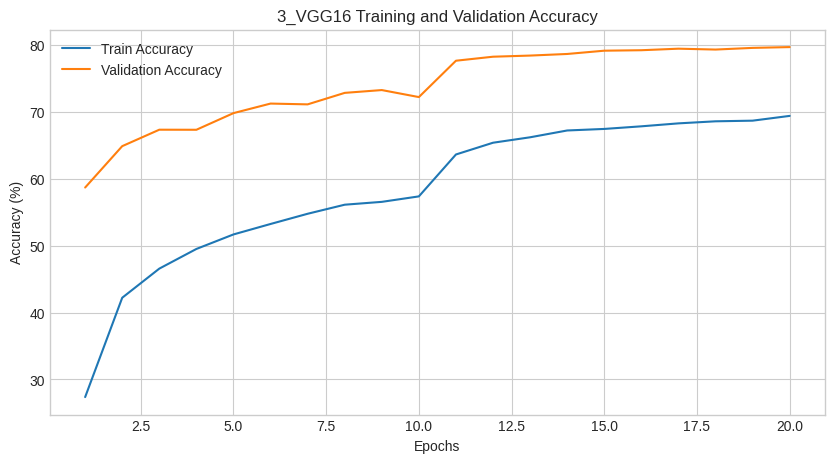

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng thiết bị: {device}")

class_names = get_cifar100_class_names(DATA_DIR)
num_classes = len(class_names)

print(f"Đang tải dữ liệu CIFAR-100 (resize: {IMG_SIZE}x{IMG_SIZE})...")
train_loader, test_loader, _ = get_cifar100_loaders(
    batch_size=BATCH_SIZE,
    data_dir=DATA_DIR,
    img_size=IMG_SIZE,
    use_augmentation=USE_AUGMENTATION,
    num_workers=NUM_WORKERS
)

if train_loader is None:
    print("Không thể tải dữ liệu. Kết thúc chương trình.")
    exit()

print("Khởi tạo VGG16 pre-trained model...")
weights = models.VGG16_BN_Weights.IMAGENET1K_V1
model = models.vgg16_bn(weights=weights)

# --- Modify the classifier for CIFAR-100 ---
# VGG's classifier is a nn.Sequential. We'll replace the last layer.
num_ftrs = model.classifier[6].in_features # Get input features of the last Linear layer
model.classifier[6] = nn.Linear(num_ftrs, num_classes) # Replace the last layer
print(f"Đã thay thế lớp cuối cùng của VGG classifier bằng lớp Linear({num_ftrs}, {num_classes})")

# (Optional) Fine-tuning strategy: Unfreeze only the classifier or last few conv blocks
# for param in model.features.parameters(): # Freeze feature extractor
#    param.requires_grad = False
# print("Feature extractor frozen. Only training classifier.")
# optimizer = optim.SGD(model.classifier.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=5e-4)

print("Bắt đầu fine-tuning VGG16...")
trained_model, train_history, test_history = train_model(
    model, train_loader, test_loader, NUM_EPOCHS, LEARNING_RATE, device, model_name=MODEL_NAME
)

# --- Final Evaluation and Visualization ---
print("\n--- Performing Final Evaluation on Test Set ---")
final_metrics = evaluate_model(trained_model, test_loader, device, num_classes, class_names)

if 'confusion_matrix' in final_metrics:
    plot_confusion_matrix(final_metrics['confusion_matrix'], class_names,
                            filename=f'{MODEL_NAME}_confusion_matrix.png',
                            figsize=(25,25))

visualize_misclassified(trained_model, test_loader, device, class_names,
                        num_images=25,
                        filename_prefix=f'{MODEL_NAME}_misclassified')

plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), train_history, label='Train Accuracy')
plt.plot(range(1, NUM_EPOCHS + 1), test_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title(f'{MODEL_NAME.upper()} Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.savefig(f'{MODEL_NAME}_accuracy_history.png')
print(f"Accuracy history plot saved to {MODEL_NAME}_accuracy_history.png")
plt.show()
